# Open a Restaurant in London Analysis
In this notebook I am to use Data Science techniques to produce valuable predictions in order to determine the best
location to open a Restaurant in London.

We shall be using data from Wikipedia which gives all the areas in London.
> link: https://en.wikipedia.org/wiki/List_of_areas_of_London

Also we shall be implementing Foursquares API in order to locate venues within the different
areas of London and then using SciKit Learns K-Means, cluster the areas into competition density by total amount of restaurants in the neighborhood.

#### Importing Libraries

In [1]:
# Import common libraries
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# import Folium and GeoPy to create and plot maps
import folium
from geopy.geocoders import Nominatim
import geocoder # import geocoder
# Import SciKit Learns KMeans model
from sklearn.cluster import KMeans
# Import necessary libraries for Foursquare
import requests
import json
from pandas.io.json import json_normalize

### Data Scraping and Data Cleaning
Here we are going to scrape the data from Wikipedia and placing it into a DataFrame using
Pandas. We will be adding the GeoLocation of each area using Pythons GeoLocator which will be
used to help plot the areas on a map with Folium and to find nearby venues with FourSquare.
When cleaning the data we will drop any rows that contain Nan values as they may
interfere with results.

In [2]:
# Scraping the data from Wikipedia page

url = 'https://en.wikipedia.org/wiki/List_of_areas_of_London'

df = pd.read_html(url, header=0)[1]
df.head()

Location                     London borough       Post town  \
0   Abbey Wood              Bexley, Greenwich [7]          LONDON   
1        Acton  Ealing, Hammersmith and Fulham[8]          LONDON   
2    Addington                         Croydon[8]         CROYDON   
3   Addiscombe                         Croydon[8]         CROYDON   
4  Albany Park                             Bexley  BEXLEY, SIDCUP   

  Postcode district Dial code OS grid ref  
0               SE2       020    TQ465785  
1            W3, W4       020    TQ205805  
2               CR0       020    TQ375645  
3               CR0       020    TQ345665  
4         DA5, DA14       020    TQ478728

Some of the column names are incorrect
* London borough
* Postcode district
* Dial code

Some of the columns are redundant which will be removed:
* Dial Code
* OsGrid Ref

In [3]:
# Rename the columns
df.rename(columns={'London\xa0borough':'London borough',
                          'Postcode\xa0district':'Postcode district',
                          'Dial\xa0code':'Dial code',
                          'Location': 'Neighborhood'},
                 inplace=True)

In [4]:
# Drop the columns which aren't relevant
df.drop(['Dial code', 'OS grid ref'], axis=1, inplace=True)


In [5]:
# Remove numbers and symbols from string values in `London Borough` columns

df['London borough'] = df['London borough'].str.replace(r'\[.*?\]', '')
df.head()

Neighborhood                  London borough       Post town  \
0   Abbey Wood              Bexley, Greenwich           LONDON   
1        Acton  Ealing, Hammersmith and Fulham          LONDON   
2    Addington                         Croydon         CROYDON   
3   Addiscombe                         Croydon         CROYDON   
4  Albany Park                          Bexley  BEXLEY, SIDCUP   

  Postcode district  
0               SE2  
1            W3, W4  
2               CR0  
3               CR0  
4         DA5, DA14

In [6]:
print(df.columns.to_list())

['Neighborhood', 'London borough', 'Post town', 'Postcode district']


### Getting the latitudes and longitudes of each Neighborhood

In [7]:
geolocator = Nominatim(country_bias="United Kingdom", user_agent='london_latlng')
list_lat = []   # create empty lists

list_long = []

for index, row in df.iterrows(): # iterate over rows in dataframe

    City = row['Neighborhood']
    State = row['Post town']
    query = str(City)+','+str(State)

    results = geolocator.geocode(query, timeout=120)
    if results:
        lat = results.latitude
        long = results.longitude

    list_lat.append(lat)
    list_long.append(long)
# create new columns from lists

df['lat'] = list_lat
df['lon'] = list_long

<ipython-input-7-a8553cd957e7>:1: DeprecationWarning: `country_bias` argument of the Nominatim.__init__ is deprecated and will be removed in geopy 2.0. Use Nominatim.geocode(country_codes='United Kingdom') instead.
  geolocator = Nominatim(country_bias="United Kingdom", user_agent='london_latlng')


In [8]:
london = df.copy()
london.head()

Neighborhood                  London borough       Post town  \
0   Abbey Wood              Bexley, Greenwich           LONDON   
1        Acton  Ealing, Hammersmith and Fulham          LONDON   
2    Addington                         Croydon         CROYDON   
3   Addiscombe                         Croydon         CROYDON   
4  Albany Park                          Bexley  BEXLEY, SIDCUP   

  Postcode district        lat        lon  
0               SE2  51.487621   0.114050  
1            W3, W4  51.508140  -0.273261  
2               CR0  44.420640 -76.978248  
3               CR0  51.379692  -0.074282  
4         DA5, DA14  51.434021   0.103430

### Plotting the neighbourhoods on a map

In [9]:
# Aquire the lat and long of London City center
address = 'London, UK'

geolocator = Nominatim(user_agent='Ldn_explorer')
location = geolocator.geocode(address)
latlon = location.latitude
longlon = location.longitude

print('The geo Coordinates of London UK are: {}, {}.'.format(latlon, longlon))

The geo Coordinates of London UK are: 51.5073219, -0.1276474.


In [10]:
# Setup Folium map
london_map = folium.Map(location=[latlon, longlon], zoom_start=10)

for lat, long, borough, neighborhood in zip(london['lat'], london['lon'], london['London borough'], london['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='darkblue',
        fill=True,
        fill_color='#38f194',
        fill_opacity=0.7,
        parse_html=False).add_to(london_map)

In [11]:
london_map

As you can see from this map there are lot of boroughs spread out over wide area. I will
reduce the boroughs to ones that are within a 5 Mile radius of London.

In [12]:
london_centre = london[london['Post town'].str.contains('LONDON')].reset_index(drop=True)
london_centre

Neighborhood                  London borough               Post town  \
0         Abbey Wood              Bexley, Greenwich                   LONDON   
1              Acton  Ealing, Hammersmith and Fulham                  LONDON   
2            Aldgate                            City                  LONDON   
3            Aldwych                     Westminster                  LONDON   
4            Anerley                         Bromley                  LONDON   
..               ...                             ...                     ...   
305         Woodford                       Redbridge                  LONDON   
306   Woodford Green       Redbridge, Waltham Forest  LONDON, WOODFORD GREEN   
307    Woodside Park                          Barnet                  LONDON   
308         Woolwich                       Greenwich                  LONDON   
309  Wormwood Scrubs          Hammersmith and Fulham                  LONDON   

    Postcode district        lat       lon  
0                 SE2  51.487621  0.114050  
1              W3, W4  51.508140 -0.273261  
2                 EC3  51.514248 -0.075719  
3                 WC2  51.513103 -0.114920  
4                SE20  51.407599 -0.061939  
..                ...        ...       ...  
305          IG8, E18  51.606806  0.034012  
306               IG8  51.611847  0.024080  
307               N12  51.617948 -0.185579  
308              SE18  51.482670  0.062334  
309               W12  51.521380 -0.240439  

[310 rows x 6 columns]

Tweak some of the incorrect lat & lng

In [13]:
# Get index
print(london_centre[london_centre['Neighborhood'].str.contains('Dartford')].index)
print(london_centre[london_centre['Neighborhood'].str.contains('Southend')].index)
print(london_centre[london_centre['Neighborhood'].str.contains('Turnpike')].index)
print(london_centre[london_centre['Neighborhood'].str.contains('Bankside')].index)

Int64Index([77], dtype='int64')
Int64Index([239], dtype='int64')
Int64Index([272], dtype='int64')
Int64Index([10], dtype='int64')


In [14]:
# Change coordinates
london_centre['lat'].iloc[239] = 51.427581
london_centre['lon'].iloc[239] = -0.015031
london_centre['lat'].iloc[10] = 51.508132
london_centre['lon'].iloc[10] = -0.095177

/home/intods/Documents/ds-projects/Coursera_Capstone/env/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
# Drop outlier rows
london_centre.drop(london_centre.index[[272 , 77]], inplace=True)

#### using the Haversine formula to calculate distance of each point from the centre of London
* using this formula to limit the neighborhoods to the ones within a 5 mile radius.

In [16]:
london_centre

Neighborhood                  London borough               Post town  \
0         Abbey Wood              Bexley, Greenwich                   LONDON   
1              Acton  Ealing, Hammersmith and Fulham                  LONDON   
2            Aldgate                            City                  LONDON   
3            Aldwych                     Westminster                  LONDON   
4            Anerley                         Bromley                  LONDON   
..               ...                             ...                     ...   
305         Woodford                       Redbridge                  LONDON   
306   Woodford Green       Redbridge, Waltham Forest  LONDON, WOODFORD GREEN   
307    Woodside Park                          Barnet                  LONDON   
308         Woolwich                       Greenwich                  LONDON   
309  Wormwood Scrubs          Hammersmith and Fulham                  LONDON   

    Postcode district        lat       lon  
0                 SE2  51.487621  0.114050  
1              W3, W4  51.508140 -0.273261  
2                 EC3  51.514248 -0.075719  
3                 WC2  51.513103 -0.114920  
4                SE20  51.407599 -0.061939  
..                ...        ...       ...  
305          IG8, E18  51.606806  0.034012  
306               IG8  51.611847  0.024080  
307               N12  51.617948 -0.185579  
308              SE18  51.482670  0.062334  
309               W12  51.521380 -0.240439  

[308 rows x 6 columns]

In [17]:
import pandas as pd
from math import *

def haversine(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1 = row[4]
    lat1 = row[5]
    lon2 = 51.5073219
    lat2 = -0.1276474
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in kilometers. Use 3956 for miles
    return c * r



london_centre['Dist'] = london_centre.apply(haversine, axis=1)

In [18]:
london_centre = london_centre[london_centre['Dist'] <=5].reset_index(drop=True)
london_centre.drop('Dist', axis=1, inplace=True)
london_centre

Neighborhood          London borough Post town Postcode district  \
0         Aldgate                    City    LONDON               EC3   
1         Aldwych             Westminster    LONDON               WC2   
2           Angel               Islington    LONDON           EC1, N1   
3         Archway               Islington    LONDON               N19   
4          Balham              Wandsworth    LONDON              SW12   
..            ...                     ...       ...               ...   
92       Walworth               Southwark    LONDON              SE17   
93        Wapping           Tower Hamlets    LONDON                E1   
94  West Brompton  Kensington and Chelsea    LONDON              SW10   
95    Westminster             Westminster    LONDON               SW1   
96    Whitechapel           Tower Hamlets    LONDON                E1   

          lat       lon  
0   51.514248 -0.075719  
1   51.513103 -0.114920  
2   51.531946 -0.106106  
3   51.565437 -0.134998  
4   51.445645 -0.150364  
..        ...       ...  
92  51.490114 -0.090660  
93  51.505436 -0.058729  
94  51.486976 -0.195185  
95  51.501356 -0.124930  
96  51.518623 -0.062081  

[97 rows x 6 columns]

In [19]:
# save new dataframe as csv and reimport
london_centre.to_csv('data/london_centre.csv', index=False)

In [20]:
london_centre = pd.read_csv('data/london_centre.csv')

# Change Post town to LONDON
london_centre['Post town'] = 'LONDON'
london_centre

Neighborhood          London borough Post town Postcode district  \
0         Aldgate                    City    LONDON               EC3   
1         Aldwych             Westminster    LONDON               WC2   
2           Angel               Islington    LONDON           EC1, N1   
3         Archway               Islington    LONDON               N19   
4          Balham              Wandsworth    LONDON              SW12   
..            ...                     ...       ...               ...   
92       Walworth               Southwark    LONDON              SE17   
93        Wapping           Tower Hamlets    LONDON                E1   
94  West Brompton  Kensington and Chelsea    LONDON              SW10   
95    Westminster             Westminster    LONDON               SW1   
96    Whitechapel           Tower Hamlets    LONDON                E1   

          lat       lon  
0   51.514248 -0.075719  
1   51.513103 -0.114920  
2   51.531946 -0.106106  
3   51.565437 -0.134998  
4   51.445645 -0.150364  
..        ...       ...  
92  51.490114 -0.090660  
93  51.505436 -0.058729  
94  51.486977 -0.195185  
95  51.501356 -0.124930  
96  51.518623 -0.062081  

[97 rows x 6 columns]

### Add population column to data

In [21]:
population = pd.read_csv('data/london_pop.csv')

In [22]:
london_centre = london_centre.merge(population.set_index('London borough'), on='London borough', how='left')
london_centre.sort_values(by='Neighborhood', ascending=True, inplace=True)
london_centre.drop('Post town_y', axis=1, inplace=True)
london_centre.rename(columns={'Post town_x':'Post town'}, inplace=True)

In [23]:
london_centre['Population'].fillna(london_centre['Population'].mean(),axis=0, inplace=True)
london_centre['Population'] = london_centre['Population'].round(2)
london_centre

Neighborhood          London borough Post town Postcode district  \
0         Aldgate                    City    LONDON               EC3   
1         Aldwych             Westminster    LONDON               WC2   
2           Angel               Islington    LONDON           EC1, N1   
3         Archway               Islington    LONDON               N19   
4          Balham              Wandsworth    LONDON              SW12   
..            ...                     ...       ...               ...   
92       Walworth               Southwark    LONDON              SE17   
93        Wapping           Tower Hamlets    LONDON                E1   
94  West Brompton  Kensington and Chelsea    LONDON              SW10   
95    Westminster             Westminster    LONDON               SW1   
96    Whitechapel           Tower Hamlets    LONDON                E1   

          lat       lon  Population  
0   51.514248 -0.075719        8.71  
1   51.513103 -0.114920      255.32  
2   51.531946 -0.106106      239.14  
3   51.565437 -0.134998      239.14  
4   51.445645 -0.150364      326.47  
..        ...       ...         ...  
92  51.490114 -0.090660      317.26  
93  51.505436 -0.058729      317.71  
94  51.486977 -0.195185      156.20  
95  51.501356 -0.124930      255.32  
96  51.518623 -0.062081      317.71  

[97 rows x 7 columns]

### Plotting the same map with less neighborhoods

In [24]:
centre_london_map = folium.Map(location=[latlon, longlon], zoom_start=10.5)

for lat, long, borough, neighborhood, pop in zip(london_centre['lat'], london_centre['lon'], london_centre['London borough'], london_centre['Neighborhood'], london_centre['Population']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='darkblue',
        fill=True,
        fill_color='#38f194',
        fill_opacity=0.7,
        parse_html=False).add_to(centre_london_map)
centre_london_map

In [25]:
centre_london_map.save('london_clusters.html')

### Using the Foursquare API to locate nearby venues
First instantiate Foursquare credentials

In [26]:
CLIENT_ID = 'NEFG3M2CXAC3TDSFEQTRPZSYZANFIQKKOBL440DFMEZ54BHE' # your Foursquare ID
CLIENT_SECRET = 'FQQXPK1ZLOXGQGK20RCSVW5IH1VD4IQKCQ25UZTKQ0QSKPM2' # your Foursquare Secret
VERSION = '20180604'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: NEFG3M2CXAC3TDSFEQTRPZSYZANFIQKKOBL440DFMEZ54BHE
CLIENT_SECRET:FQQXPK1ZLOXGQGK20RCSVW5IH1VD4IQKCQ25UZTKQ0QSKPM2


### Get 100 venues with a 500m Radius of each Neighborhood

In [27]:
#set limit on amount of venues to grab
LIMIT = 100
# define a function to get all venues within a certain radius of each neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):

    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
        results = requests.get(url).json()['response']['groups'][0]['items']

        venues_list.append([(
            name,
            lat,
            long,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name'])for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']
    return(nearby_venues)

In [28]:
london_venues = getNearbyVenues(names=london_centre['Neighborhood'],
                                latitudes=london_centre['lat'],
                                longitudes=london_centre['lon'])

london_venues = pd.DataFrame(data=london_venues)

Aldgate
Aldwych
Angel
Archway
Balham
Bankside
Barbican
Barnsbury
Battersea
Bayswater
Belgravia
Belsize Park
Bermondsey
Blackfriars
Bloomsbury
Brixton
Brompton
Camberwell
Camden Town
Canonbury
Chalk Farm
Charing Cross
Chelsea
Chinatown
Clapham
Clerkenwell
Covent Garden
Crouch End
Custom House
Dalston
De Beauvoir Town
Denmark Hill
Earls Court
Elephant and Castle
Farringdon
Finsbury
Finsbury Park
Fitzrovia
Gospel Oak
Haggerston
Hampstead
Herne Hill
Highbury
Highgate
Holborn
Holloway
Hoxton
Islington
Kennington
Kensington
Kentish Town
King's Cross
Knightsbridge
Lambeth
Lisson Grove
Little Venice
Maida Vale
Manor House
Mayfair
Millbank
Nag's Head
Newington
Nine Elms
Oval
Paddington
Peckham
Pentonville
Pimlico
Primrose Hill
Sands End
Shadwell
Shoreditch
Soho
Somerstown
South Kensington
Spitalfields
St Giles
St James's
St John's Wood
St Luke's
St Pancras
Stockwell
Stoke Newington
Stroud Green
Swiss Cottage
Sydenham (also Lower Sydenham, Upper Sydenham)
Temple
Tower Hill
Tufnell Park
Tulse Hil

In [29]:
london_venues.head()


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0      Aldgate              51.514248               -0.062081   
1      Aldgate              51.514248               -0.062081   
2      Aldgate              51.514248               -0.062081   
3      Aldgate              51.514248               -0.062081   
4      Aldgate              51.514248               -0.062081   

                 Venue  Venue Latitude  Venue Longitude Venue Category  
0         Hotel Indigo       51.512740        -0.075920          Hotel  
1            Benk + Bo       51.515731        -0.075875         Bakery  
2    1n1 Fashion Pizza       51.516037        -0.075865    Pizza Place  
3  Dorsett City London       51.514036        -0.075812          Hotel  
4      The Association       51.513733        -0.079132    Coffee Shop

### Creating a DataFrame with only Restaurants

In [30]:
london_restaurants = london_venues[london_venues['Venue Category'].str.contains('Restaurant').reset_index(drop=True)]
london_restaurants

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
8         Aldgate              51.514248               -0.062081   
10        Aldgate              51.514248               -0.062081   
11        Aldgate              51.514248               -0.062081   
12        Aldgate              51.514248               -0.062081   
18        Aldgate              51.514248               -0.062081   
...           ...                    ...                     ...   
5101  Whitechapel              51.518623               -0.062081   
5115  Whitechapel              51.518623               -0.062081   
5117  Whitechapel              51.518623               -0.062081   
5118  Whitechapel              51.518623               -0.062081   
5122  Whitechapel              51.518623               -0.062081   

                              Venue  Venue Latitude  Venue Longitude  \
8              The Japanese Canteen       51.513775        -0.079079   
10                       Mattarello       51.515518        -0.075434   
11                             Bife       51.515700        -0.075438   
12                    Treves & Hyde       51.514114        -0.070606   
18                         Tifinbox       51.516345        -0.077195   
...                             ...             ...              ...   
5101                   Maedah Grill       51.516887        -0.065522   
5115                       Kolapata       51.519742        -0.057233   
5117                    Wok & Grill       51.519982        -0.055918   
5118                Chicken Cottage       51.514942        -0.062318   
5122  Korean BBQ & Vegan Restaurant       51.519983        -0.056017   

              Venue Category  
8        Japanese Restaurant  
10        Italian Restaurant  
11    Argentinian Restaurant  
12                Restaurant  
18         Indian Restaurant  
...                      ...  
5101      Turkish Restaurant  
5115        Asian Restaurant  
5117    Fast Food Restaurant  
5118    Fast Food Restaurant  
5122       Korean Restaurant  

[1098 rows x 7 columns]

In [31]:
# Drop Fast food chains
london_restaurants = london_restaurants[~london_restaurants['Venue Category'].str.contains('Fast')]
london_restaurants.reset_index(drop=True)

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Aldgate              51.514248               -0.062081   
1         Aldgate              51.514248               -0.062081   
2         Aldgate              51.514248               -0.062081   
3         Aldgate              51.514248               -0.062081   
4         Aldgate              51.514248               -0.062081   
...           ...                    ...                     ...   
1066  Whitechapel              51.518623               -0.062081   
1067  Whitechapel              51.518623               -0.062081   
1068  Whitechapel              51.518623               -0.062081   
1069  Whitechapel              51.518623               -0.062081   
1070  Whitechapel              51.518623               -0.062081   

                              Venue  Venue Latitude  Venue Longitude  \
0              The Japanese Canteen       51.513775        -0.079079   
1                        Mattarello       51.515518        -0.075434   
2                              Bife       51.515700        -0.075438   
3                     Treves & Hyde       51.514114        -0.070606   
4                          Tifinbox       51.516345        -0.077195   
...                             ...             ...              ...   
1066             Lahore Kebab House       51.514483        -0.062912   
1067                     Lahore One       51.514725        -0.059399   
1068                   Maedah Grill       51.516887        -0.065522   
1069                       Kolapata       51.519742        -0.057233   
1070  Korean BBQ & Vegan Restaurant       51.519983        -0.056017   

              Venue Category  
0        Japanese Restaurant  
1         Italian Restaurant  
2     Argentinian Restaurant  
3                 Restaurant  
4          Indian Restaurant  
...                      ...  
1066        Kebab Restaurant  
1067       Indian Restaurant  
1068      Turkish Restaurant  
1069        Asian Restaurant  
1070       Korean Restaurant  

[1071 rows x 7 columns]

In [32]:
london_restaurants.to_csv('data/london_restaurants.csv', index=False)

In [33]:
london_restaurants = pd.read_csv('data/london_restaurants.csv')

### Get the number of unique Restaurants in the DataFrame

In [34]:
london_restaurants.groupby('Neighborhood').count()
print('In London Centre there are {} unique Restaurants.'.format(len(london_restaurants['Venue'].unique())))
london_restaurants.head()

In London Centre there are 791 unique Restaurants.


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0      Aldgate              51.514248               -0.062081   
1      Aldgate              51.514248               -0.062081   
2      Aldgate              51.514248               -0.062081   
3      Aldgate              51.514248               -0.062081   
4      Aldgate              51.514248               -0.062081   

                  Venue  Venue Latitude  Venue Longitude  \
0  The Japanese Canteen       51.513775        -0.079079   
1            Mattarello       51.515518        -0.075434   
2                  Bife       51.515700        -0.075438   
3         Treves & Hyde       51.514114        -0.070606   
4              Tifinbox       51.516345        -0.077195   

           Venue Category  
0     Japanese Restaurant  
1      Italian Restaurant  
2  Argentinian Restaurant  
3              Restaurant  
4       Indian Restaurant

In [35]:
rest_london_map = folium.Map(location=[latlon, longlon], zoom_start=10.5)



for lat, long, venue, neighborhood in zip(london_restaurants['Venue Latitude'], london_restaurants['Venue Longitude'], london_restaurants['Venue'], london_restaurants['Neighborhood']):
    label = '{}, {}'.format(venue, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='lightgreen',
        fill_opacity=0.7,
        parse_html=False).add_to(rest_london_map)
rest_london_map

In [36]:
rest_london_map.save('restaurants_london_map.html')

### Convert the columns into 0 or 1 using pandas OneHotEncoding

In [37]:
london_enc = pd.get_dummies(london_restaurants[['Venue Category']], prefix='', prefix_sep='')

In [38]:
london_enc['Neighborhood'] = london_restaurants['Neighborhood']


# Move Neighborhood to the first row.
fixed_features = [london_enc.columns[-1]] + list(london_enc.drop('Neighborhood', axis=1))
london_enc = london_enc[fixed_features]

In [39]:
london_enc.head()

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0      Aldgate                  0                   0                    0   
1      Aldgate                  0                   0                    0   
2      Aldgate                  0                   0                    0   
3      Aldgate                  0                   0                    0   
4      Aldgate                  0                   0                    0   

   Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
0                 0                       0                 0   
1                 0                       0                 0   
2                 0                       1                 0   
3                 0                       0                 0   
4                 0                       0                 0   

   Austrian Restaurant  Belgian Restaurant  Brazilian Restaurant  ...  \
0                    0                   0                     0  ...   
1                    0                   0                     0  ...   
2                    0                   0                     0  ...   
3                    0                   0                     0  ...   
4                    0                   0                     0  ...   

   Spanish Restaurant  Sushi Restaurant  Szechuan Restaurant  \
0                   0                 0                    0   
1                   0                 0                    0   
2                   0                 0                    0   
3                   0                 0                    0   
4                   0                 0                    0   

   Tapas Restaurant  Thai Restaurant  Turkish Restaurant  Udon Restaurant  \
0                 0                0                   0                0   
1                 0                0                   0                0   
2                 0                0                   0                0   
3                 0                0                   0                0   
4                 0                0                   0                0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  Xinjiang Restaurant  
0                              0                      0                    0  
1                              0                      0                    0  
2                              0                      0                    0  
3                              0                      0                    0  
4                              0                      0                    0  

[5 rows x 67 columns]

### Getting the sum of all the restaurants within each Neighborhood

In [40]:
london_grouped = london_enc.groupby('Neighborhood').sum().reset_index()
london_grouped

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0         Aldgate                  0                   0                    1   
1         Aldwych                  0                   0                    0   
2           Angel                  1                   0                    0   
3         Archway                  0                   0                    0   
4          Balham                  0                   0                    0   
..            ...                ...                 ...                  ...   
91       Walworth                  0                   0                    0   
92        Wapping                  0                   0                    0   
93  West Brompton                  0                   0                    0   
94    Westminster                  0                   0                    0   
95    Whitechapel                  0                   0                    0   

    Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
0                  0                       1                 2   
1                  0                       1                 0   
2                  0                       0                 0   
3                  0                       0                 1   
4                  0                       0                 0   
..               ...                     ...               ...   
91                 0                       0                 1   
92                 0                       0                 0   
93                 0                       0                 0   
94                 0                       0                 0   
95                 0                       0                 1   

    Austrian Restaurant  Belgian Restaurant  Brazilian Restaurant  ...  \
0                     0                   0                     0  ...   
1                     0                   0                     0  ...   
2                     1                   0                     0  ...   
3                     0                   0                     0  ...   
4                     0                   0                     0  ...   
..                  ...                 ...                   ...  ...   
91                    0                   0                     0  ...   
92                    0                   0                     0  ...   
93                    0                   0                     0  ...   
94                    0                   0                     0  ...   
95                    0                   0                     0  ...   

    Spanish Restaurant  Sushi Restaurant  Szechuan Restaurant  \
0                    0                 2                    1   
1                    0                 0                    0   
2                    0                 1                    0   
3                    0                 0                    0   
4                    0                 0                    0   
..                 ...               ...                  ...   
91                   0                 0                    0   
92                   0                 0                    0   
93                   0                 0                    0   
94                   0                 0                    0   
95                   0                 0                    0   

    Tapas Restaurant  Thai Restaurant  Turkish Restaurant  Udon Restaurant  \
0                  0                3                   0                0   
1                  1                0                   1                0   
2                  0                0                   1                0   
3                  0                0                   0                0   
4                  0                0                   0                0   
..               ...              ...                 ...              ...   
91                 0   

### Create DataFrame that contains the `Neighborhood` & `Total` column 

In [41]:
london_grouped['Total'] = london_grouped.sum(axis=1)
london_grouped

Neighborhood  Afghan Restaurant  African Restaurant  American Restaurant  \
0         Aldgate                  0                   0                    1   
1         Aldwych                  0                   0                    0   
2           Angel                  1                   0                    0   
3         Archway                  0                   0                    0   
4          Balham                  0                   0                    0   
..            ...                ...                 ...                  ...   
91       Walworth                  0                   0                    0   
92        Wapping                  0                   0                    0   
93  West Brompton                  0                   0                    0   
94    Westminster                  0                   0                    0   
95    Whitechapel                  0                   0                    0   

    Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
0                  0                       1                 2   
1                  0                       1                 0   
2                  0                       0                 0   
3                  0                       0                 1   
4                  0                       0                 0   
..               ...                     ...               ...   
91                 0                       0                 1   
92                 0                       0                 0   
93                 0                       0                 0   
94                 0                       0                 0   
95                 0                       0                 1   

    Austrian Restaurant  Belgian Restaurant  Brazilian Restaurant  ...  \
0                     0                   0                     0  ...   
1                     0                   0                     0  ...   
2                     1                   0                     0  ...   
3                     0                   0                     0  ...   
4                     0                   0                     0  ...   
..                  ...                 ...                   ...  ...   
91                    0                   0                     0  ...   
92                    0                   0                     0  ...   
93                    0                   0                     0  ...   
94                    0                   0                     0  ...   
95                    0                   0                     0  ...   

    Sushi Restaurant  Szechuan Restaurant  Tapas Restaurant  Thai Restaurant  \
0                  2                    1                 0                3   
1                  0                    0                 1                0   
2                  1                    0                 0                0   
3                  0                    0                 0                0   
4                  0                    0                 0                0   
..               ...                  ...               ...              ...   
91                 0                    0                 0                1   
92                 0                    0                 0                0   
93                 0                    0                 0                0   
94                 0                    0                 0                0   
95                 0                    0                 0                0   

    Turkish Restaurant  Udon Restaurant  Vegetarian / Vegan Restaurant  \
0                    0                0                              0   
1                    1                0                              1   
2                    1                0                              0   
3                    0                0                              1   
4                  

In [43]:
# This is data set to be used with Kmeans
london_total = london_grouped[['Neighborhood', 'Total']]
london_total

Neighborhood  Total
0         Aldgate     30
1         Aldwych     12
2           Angel     17
3         Archway      7
4          Balham      9
..            ...    ...
91       Walworth      5
92        Wapping      4
93  West Brompton      1
94    Westminster      4
95    Whitechapel      8

[96 rows x 2 columns]

### Use K means clustering to group the neighborhoods by total amount of restaurants

#### Implimenting the KMeans models

In [44]:
# create variable for use with KMeans
london_grouped_cluster = london_total.drop('Neighborhood', 1)

In [45]:
k_clusters = 3

kmeans = KMeans(n_clusters=k_clusters, random_state=4).fit(london_grouped_cluster)
print('There are {} labels'.format(len(kmeans.labels_)))

There are 96 labels


### Create DataFrame that contains information about each Neighborhood and the cluster labels

In [46]:
london_total.insert(0, 'Cluster Labels', kmeans.labels_)

In [47]:
london_merged = london_centre

london_merged = london_merged.merge(london_total.set_index('Neighborhood'), on='Neighborhood')

In [48]:
london_merged

Neighborhood          London borough Post town Postcode district  \
0         Aldgate                    City    LONDON               EC3   
1         Aldwych             Westminster    LONDON               WC2   
2           Angel               Islington    LONDON           EC1, N1   
3         Archway               Islington    LONDON               N19   
4          Balham              Wandsworth    LONDON              SW12   
..            ...                     ...       ...               ...   
91       Walworth               Southwark    LONDON              SE17   
92        Wapping           Tower Hamlets    LONDON                E1   
93  West Brompton  Kensington and Chelsea    LONDON              SW10   
94    Westminster             Westminster    LONDON               SW1   
95    Whitechapel           Tower Hamlets    LONDON                E1   

          lat       lon  Population  Cluster Labels  Total  
0   51.514248 -0.075719        8.71               2     30  
1   51.513103 -0.114920      255.32               1     12  
2   51.531946 -0.106106      239.14               1     17  
3   51.565437 -0.134998      239.14               0      7  
4   51.445645 -0.150364      326.47               0      9  
..        ...       ...         ...             ...    ...  
91  51.490114 -0.090660      317.26               0      5  
92  51.505436 -0.058729      317.71               0      4  
93  51.486977 -0.195185      156.20               0      1  
94  51.501356 -0.124930      255.32               0      4  
95  51.518623 -0.062081      317.71               0      8  

[96 rows x 9 columns]

### Create map with:
* Coloured points representing each neighborhood and sized depending on total
* Choropleth map showing the population density in each borough

In [49]:
london_clusters = []

In [61]:
london_clusters= folium.Map(location=[latlon, longlon], zoom_start=12)
borough_geo = r'data/london_boroughs.json'
borough_pop = pd.read_csv('data/london_pop.csv')

#Choropleth map population Denisty
folium.Choropleth(
    geo_data=borough_geo,
    name='choropleth',
    data=borough_pop,
    columns=['London borough', 'Population'],
    key_on='feature.properties.name',
    fill_color='YlOrBr',
    fill_opacity=0.4,
    line_opacity=0.5,
    legend_name='Population (1000)'
).add_to(london_clusters)

folium.LayerControl().add_to(london_clusters)

# Markers for the map
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.brg(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, total in zip(london_merged['lat'], london_merged['lon'], london_merged['Neighborhood'], london_merged['Cluster Labels'], london_merged['Total']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' ' + str(pop), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=total*10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(london_clusters)
london_clusters

In [51]:
london_clusters.save('london_final.html')

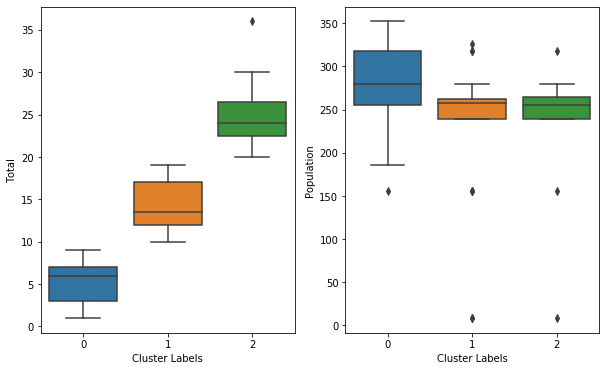

In [52]:
fig, axs = plt.subplots(ncols=2, figsize=(10,6))

sns.boxplot(london_merged['Cluster Labels'], london_merged.Total, ax=axs[0])
sns.boxplot(london_merged['Cluster Labels'], london_merged.Population, ax=axs[1])

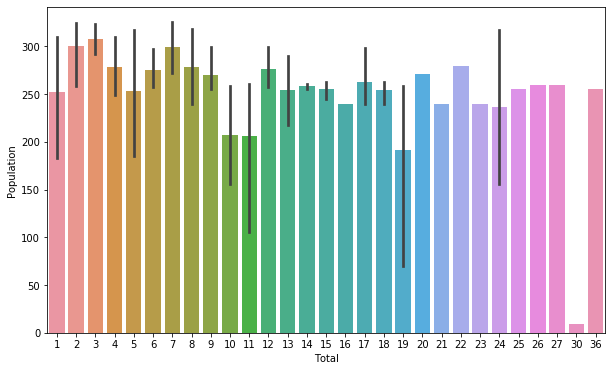

In [53]:
fig, axs = plt.subplots(figsize=(10,6))

sns.barplot(london_merged.Total, london_merged.Population)

### Examine each cluster label and determine which cluster relates to Low, Medium or High restaurant density

In [54]:
# Medium Green
london_med = london_merged.loc[london_merged['Cluster Labels'] == 0]
london_med

Neighborhood          London borough Post town Postcode district  \
3            Archway               Islington    LONDON               N19   
4             Balham              Wandsworth    LONDON              SW12   
7          Barnsbury               Islington    LONDON                N1   
8          Battersea              Wandsworth    LONDON              SW11   
10         Belgravia             Westminster    LONDON               SW1   
12        Bermondsey               Southwark    LONDON               SE1   
14        Bloomsbury                  Camden    LONDON               WC1   
15           Brixton                 Lambeth    LONDON     SW2, SW9, SE5   
19         Canonbury               Islington    LONDON                N1   
21     Charing Cross             Westminster    LONDON               WC2   
28      Custom House                  Newham    LONDON               E16   
29           Dalston                 Hackney    LONDON                E8   
30  De Beauvoir Town               Islington    LONDON                N1   
31      Denmark Hill               Southwark    LONDON               SE5   
38        Gospel Oak                  Camden    LONDON          NW5, NW3   
39        Haggerston                 Hackney    LONDON                E2   
41        Herne Hill                 Lambeth    LONDON              SE24   
43          Highgate                  Camden    LONDON                N6   
46            Hoxton                 Hackney    LONDON                N1   
48        Kennington      Lambeth, Southwark    LONDON              SE11   
51      King's Cross    Camden and Islington    LONDON               WC1   
54      Lisson Grove             Westminster    LONDON               NW8   
55     Little Venice             Westminster    LONDON            W9, W2   
56        Maida Vale             Westminster    LONDON                W9   
60         Newington               Southwark    LONDON         SE1, SE17   
61         Nine Elms              Wandsworth    LONDON               SW8   
62              Oval                 Lambeth    LONDON    SW8, SW9, SE11   
64           Peckham               Southwark    LONDON              SE15   
67     Primrose Hill                  Camden    LONDON     NW1, NW3, NW8   
68         Sands End  Hammersmith and Fulham    LONDON               SW6   
69          Shadwell           Tower Hamlets    LONDON                E1   
74      Spitalfields           Tower Hamlets    LONDON                E1   
76        St James's             Westminster    LONDON               SW1   
77    St John's Wood             Westminster    LONDON               NW8   
80         Stockwell                 Lambeth    LONDON          SW8, SW9   
85            Temple       City, Westminster    LONDON          EC4, WC2   
86        Tower Hill           Tower Hamlets    LONDON               EC3   
88        Tulse Hill                 Lambeth    LONDON        SE24, SE27   
89    Upper Holloway               Islington    LONDON               N19   
90          Vauxhall                 Lambeth    LONDON               SW8   
91          Walworth               Southwark    LONDON              SE17   
92           Wapping           Tower Hamlets    LONDON                E1   
93     West Brompton  Kensington and Chelsea    LONDON              SW10   
94       Westminster             Westminster    LONDON               SW1   
95       Whitechapel           Tower Hamlets    LONDON                E1   

          lat       lon  Population  Cluster Labels  Total  
3   51.565437 -0.134998      239.14               0      7  
4   51.445645 -0.150364      326.47               0      9  
7   51.538935 -0.114735      239.14               0      4  
8   51.470793 -0.172214      326.47               0      7  
10  51.498213 -0.153500      255.32               0      7  
12  51.497012 -0.063268      317.26               0      2  
14  51.523126 -0.126066      262.23               0      6  
15  51.456804 -0.116796

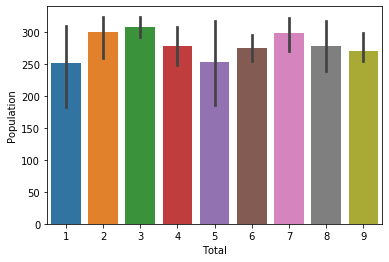

In [55]:
sns.barplot(london_med.Total, london_med.Population)

In [56]:
# Low Blue
london_low = london_merged.loc[london_merged['Cluster Labels'] == 1]
london_low

Neighborhood          London borough  \
1                                          Aldwych             Westminster   
2                                            Angel               Islington   
6                                         Barbican                    City   
11                                    Belsize Park                  Camden   
13                                     Blackfriars                    City   
17                                      Camberwell               Southwark   
18                                     Camden Town                  Camden   
20                                      Chalk Farm                  Camden   
22                                         Chelsea  Kensington and Chelsea   
23                                       Chinatown             Westminster   
26                                   Covent Garden             Westminster   
32                                     Earls Court  Kensington and Chelsea   
33                             Elephant and Castle               Southwark   
34                                      Farringdon        Islington & City   
36                                   Finsbury Park     Haringey, Islington   
37                                       Fitzrovia                  Camden   
40                                       Hampstead                  Camden   
42                                        Highbury               Islington   
44                                         Holborn                  Camden   
45                                        Holloway               Islington   
47                                       Islington               Islington   
49                                      Kensington  Kensington and Chelsea   
50                                    Kentish Town                  Camden   
53                                         Lambeth                 Lambeth   
57                                         Mayfair             Westminster   
58                                        Millbank             Westminster   
59                                      Nag's Head               Islington   
63                                      Paddington             Westminster   
65                                     Pentonville               Islington   
66                                         Pimlico             Westminster   
71                                            Soho             Westminster   
72                                      Somerstown                  Camden   
75                                        St Giles                  Camden   
78                                       St Luke's               Islington   
79                                      St Pancras                  Camden   
81                                 Stoke Newington                 Hackney   
82                                    Stroud Green                Haringey   
83                                   Swiss Cottage                  Camden   
84  Sydenham (also Lower Sydenham, Upper Sydenham)       Lewisham, Bromley   
87                                    Tufnell Park       Islington, Camden   

   Post town Postcode district        lat       lon  Population  \
1     LONDON               WC2  51.513103 -0.114920      255.32   
2     LONDON           EC1, N1  51.531946 -0.106106      239.14   
6     LONDON               EC1  51.520150 -0.098683        8.71   
11    LONDON               NW3  51.547393 -0.168301      262.23   
13    LONDON               EC4  51.511585 -0.103767        8.71   
17    LONDON               SE5  51.474571 -0.092542      317.26   
18    LONDON               NW1  51.542305 -0.139560      262.23   
20    LONDON               NW1  51.544114 -0.153481      262.23   
22    LONDON               SW3  51.487542 -0.168220      156.20   
23    LONDON                W1  51.511680 -0.130496      255.32   
26    LONDON               WC2  51.512874 -0.122544      255.32   
32    LONDON         SW5, SW10  51.

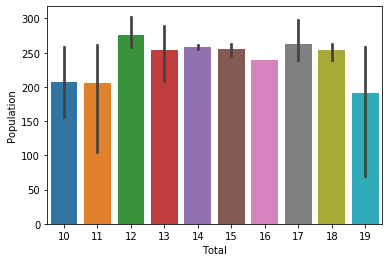

In [57]:
sns.barplot(london_low.Total, london_low.Population)

In [58]:
# High Red
london_high = london_merged.loc[london_merged['Cluster Labels'] == 2]
london_high

Neighborhood                                London borough Post town  \
0            Aldgate                                          City    LONDON   
5           Bankside                                     Southwark    LONDON   
9          Bayswater                                   Westminster    LONDON   
16          Brompton  Kensington and ChelseaHammersmith and Fulham    LONDON   
24           Clapham                           Lambeth, Wandsworth    LONDON   
25       Clerkenwell                                     Islington    LONDON   
27        Crouch End                                      Haringey    LONDON   
35          Finsbury                                     Islington    LONDON   
52     Knightsbridge                                   Westminster    LONDON   
70        Shoreditch                                       Hackney    LONDON   
73  South Kensington                        Kensington and Chelsea    LONDON   

   Postcode district        lat       lon  Population  Cluster Labels  Total  
0                EC3  51.514248 -0.075719        8.71               2     30  
5                SE1  51.508132 -0.095177      317.26               2     24  
9                 W2  51.512276 -0.188385      255.32               2     36  
16               SW3  51.491822 -0.178326      259.41               2     27  
24               SW4  51.462292 -0.138856      259.41               2     26  
25               EC1  51.523727 -0.105556      239.14               2     23  
27                N8  51.578740 -0.123599      270.62               2     20  
35               EC1  51.526574 -0.107071      239.14               2     21  
52               SW1  51.500844 -0.166965      255.32               2     25  
70                N1  51.526669 -0.079893      279.67               2     22  
73     SW7, SW3, SW5  51.494049 -0.173044      156.20               2     24

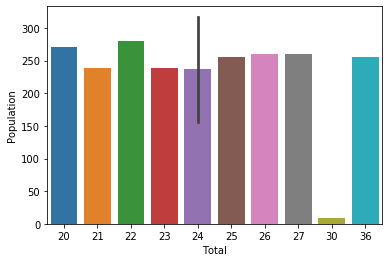

In [59]:
sns.barplot(london_high.Total, london_high.Population)

As you can see from each cluster, Cluster 2 (Red) has the highest density of Restaurants and cluster 1 (Blue) has the lowest. Therefor if a client was looking to open up a restaurant it would be ideal to go for cluster 1. Also as cluster 0 (red) has quite a low total of restaurants this could be an alternative area and is worth considering.